Install & Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import statsmodels.api as sm

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


Load Stock Market Data

In [3]:
def load_data(ticker='AAPL', start='2019-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    return df

df = load_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Display first few rows

In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.667183,37.889009,36.787041,36.944466,148158800
2019-01-03,33.915268,34.757246,33.869948,34.342219,365248800
2019-01-04,35.363079,35.432252,34.299279,34.473398,234428400
2019-01-07,35.284363,35.499034,34.800166,35.468025,219111200
2019-01-08,35.956982,36.212200,35.425082,35.673142,164101200


 Exploratory Data Analysis (EDA)

In [5]:
print("Data Overview:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())

Data Overview:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.667183  37.889009  36.787041  36.944466  148158800
2019-01-03  33.915268  34.757246  33.869948  34.342219  365248800
2019-01-04  35.363079  35.432252  34.299279  34.473398  234428400
2019-01-07  35.284363  35.499034  34.800166  35.468025  219111200
2019-01-08  35.956982  36.212200  35.425082  35.673142  164101200

Missing Values:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Statistical Summary:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03
mean     120.843221   122.108680   119.438978   120.720124  1.015904e+0

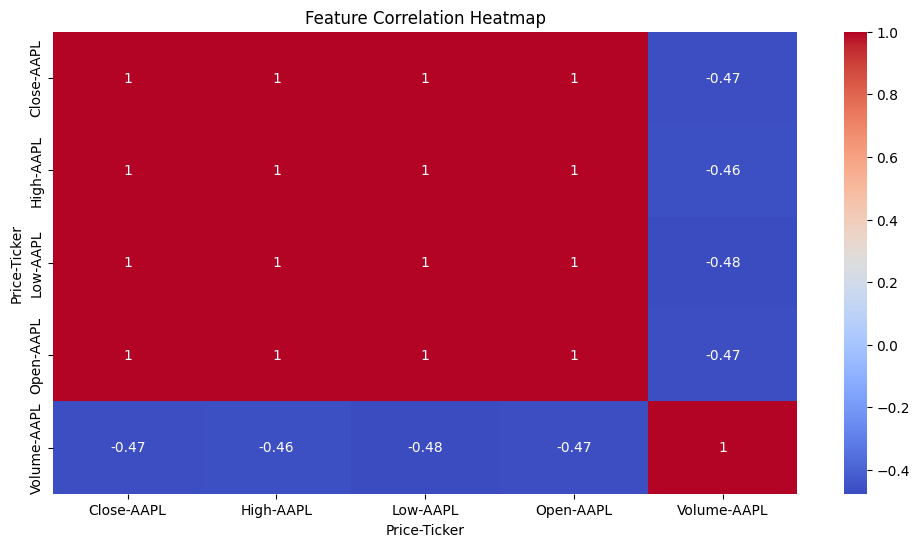

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

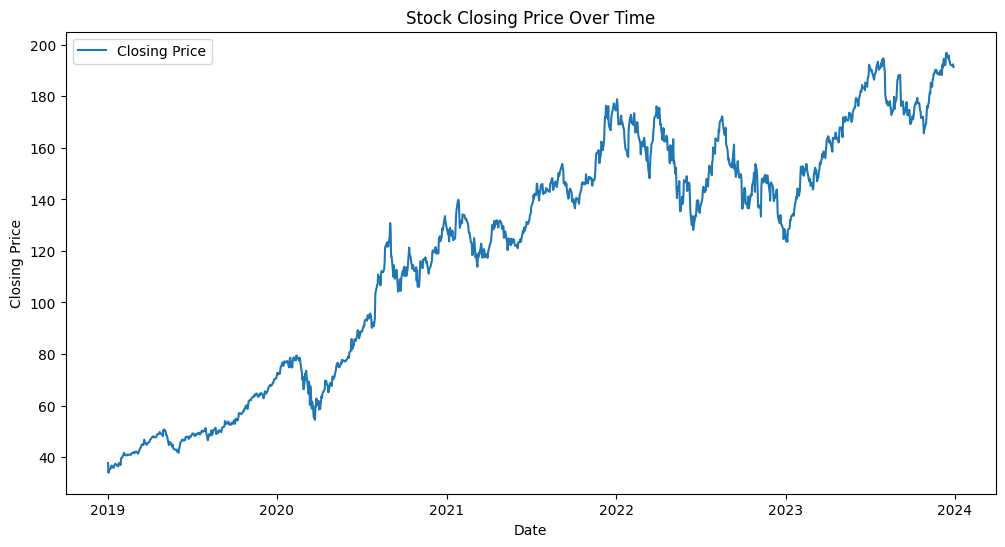

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Closing Price')
plt.title("Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

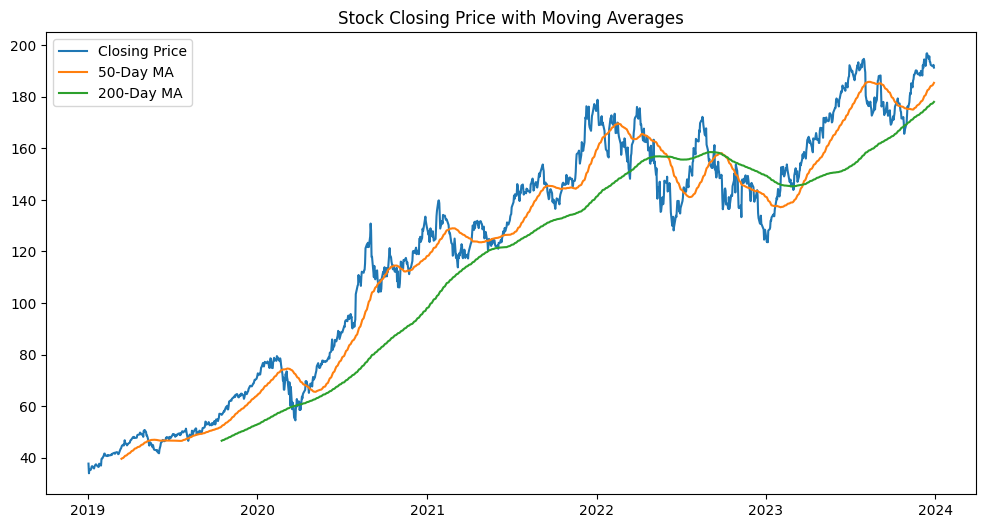

In [8]:
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Closing Price')
plt.plot(df['50_MA'], label='50-Day MA')
plt.plot(df['200_MA'], label='200-Day MA')
plt.legend()
plt.title("Stock Closing Price with Moving Averages")
plt.show()

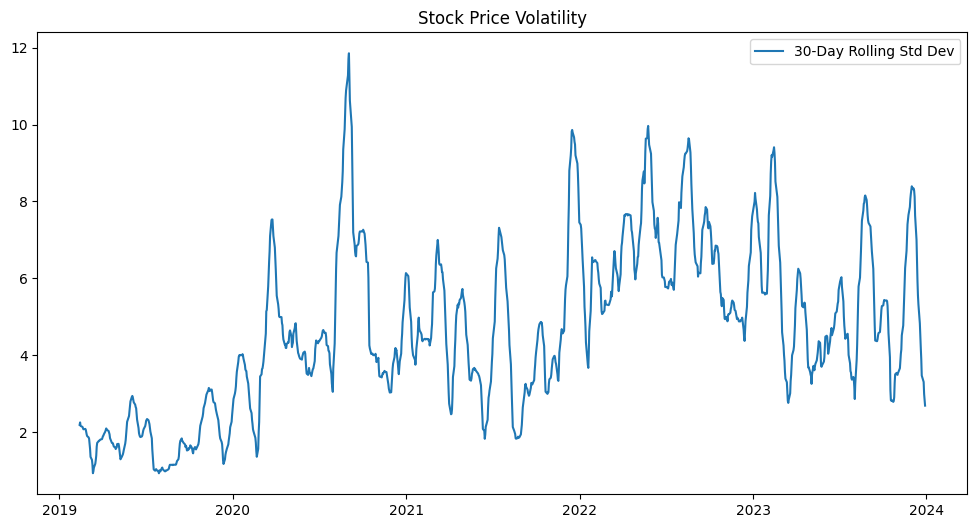

In [9]:
df['Volatility'] = df['Close'].rolling(window=30).std()
plt.figure(figsize=(12,6))
plt.plot(df['Volatility'], label='30-Day Rolling Std Dev')
plt.legend()
plt.title("Stock Price Volatility")
plt.show()

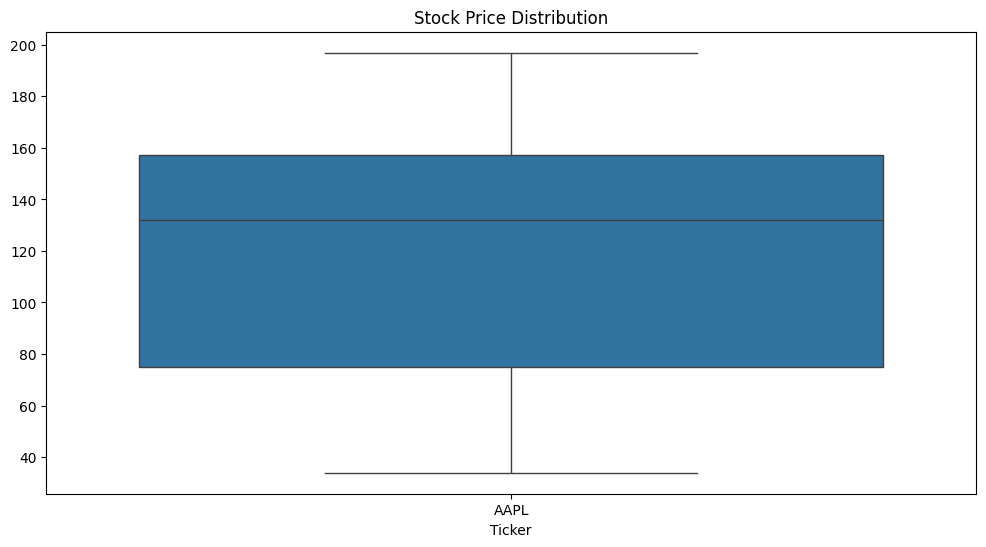

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(df['Close'])
plt.title("Stock Price Distribution")
plt.show()

<Figure size 1200x1000 with 0 Axes>

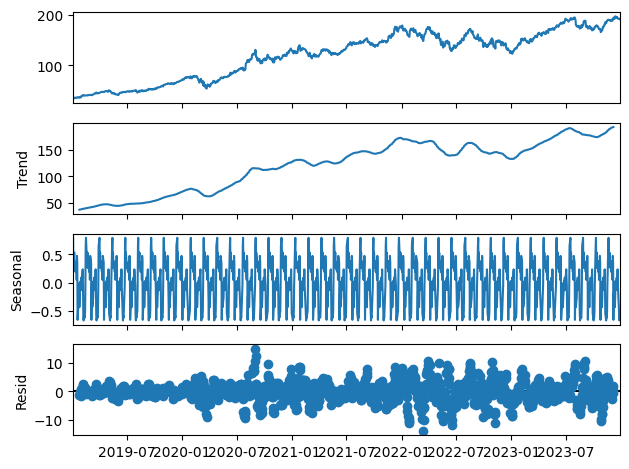

In [11]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)
plt.figure(figsize=(12,10))
decomposition.plot()
plt.show()

Preprocess Data for LSTM & GRU

In [12]:
# Preprocess Data Cell
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['Close']])

    X, y = [], []
    lookback = 60  # Use past 60 days to predict next day's close

    for i in range(lookback, len(df_scaled)):
        X.append(df_scaled[i-lookback:i, 0])
        y.append(df_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(df)


Define the LSTM Model with Hyperparameter Tuning

In [13]:
def build_lstm_model(hp):
    model = Sequential()

    units = hp.Int('units', min_value=50, max_value=128, step=16)  # Tuning LSTM units
    dropout_rate = hp.Choice('dropout', values=[0.2, 0.3, 0.4])  # Tuning dropout

    model.add(LSTM(units, return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(hp.Int('dense_units', min_value=25, max_value=100, step=25)))  # Tuning Dense Layer
    model.add(Dense(1))

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model
#stm_model = build_lstm_model((X_train.shape[1], 1))

#lstm_model = build_lstm_model((X_train.shape[1], 1))

Tune Hyperparameters for the LSTM Model

In [14]:
from kerastuner.tuners import Hyperband

# Create a tuner for hyperparameter optimization
tuner = Hyperband(
    build_lstm_model,  # Pass function, not input shape
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuning_dir',
    project_name='lstm_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model using the best parameters
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Trial 90 Complete [00h 00m 26s]
val_loss: 0.0008306234958581626

Best val_loss So Far: 0.0006487520295195282
Total elapsed time: 00h 13m 08s
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1022 - val_loss: 0.0023
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 11

Evaluate and Visualize LSTM Model Predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9614e-04
Test Loss: 0.0010698835831135511
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


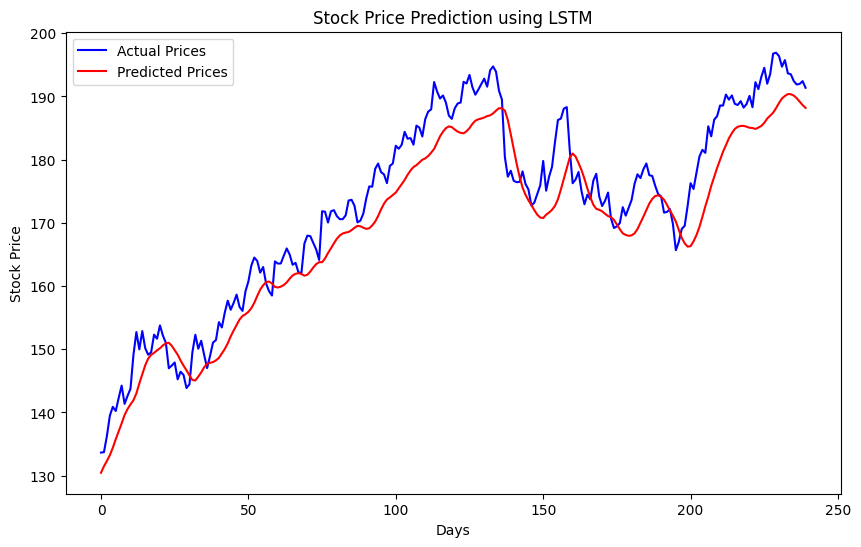

In [15]:
# Evaluate the model on the test set
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
predictions = best_model.predict(X_test)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction using LSTM")
plt.show()


Define the GRU Model with Hyperparameter Tuning

In [16]:
def build_gru_model(hp):
    model = Sequential()

    units = hp.Int('units', min_value=50, max_value=128, step=16)  # Tuning GRU units
    dropout_rate = hp.Choice('dropout', values=[0.2, 0.3, 0.4])  # Tuning dropout

    model.add(GRU(units, return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(dropout_rate))

    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(hp.Int('dense_units', min_value=25, max_value=100, step=25)))  # Tuning Dense Layer
    model.add(Dense(1))

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model


Tune Hyperparameters for the GRU Model

In [17]:
# Create a tuner for GRU hyperparameter optimization
tuner_gru = Hyperband(
    build_gru_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuning_dir',
    project_name='gru_tuning'
)

# Perform hyperparameter search
tuner_gru.search(X_train, y_train, epochs=50, validation_split=0.1, batch_size=32)

# Get the best hyperparameters
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

# Build and train the GRU model using the best parameters
best_gru_model = tuner_gru.hypermodel.build(best_hps_gru)
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Trial 90 Complete [00h 00m 28s]
val_loss: 0.0006700984667986631

Best val_loss So Far: 0.0004649377951864153
Total elapsed time: 00h 15m 33s
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0573 - val_loss: 0.0019
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - val_loss: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 6.5690e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 7.6451e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 6.8409e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 8.3091e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 7.0419e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_lo

Evaluate and Visualize GRU Model Predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3438e-04  
Test Loss (GRU): 0.0005891441251151264
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


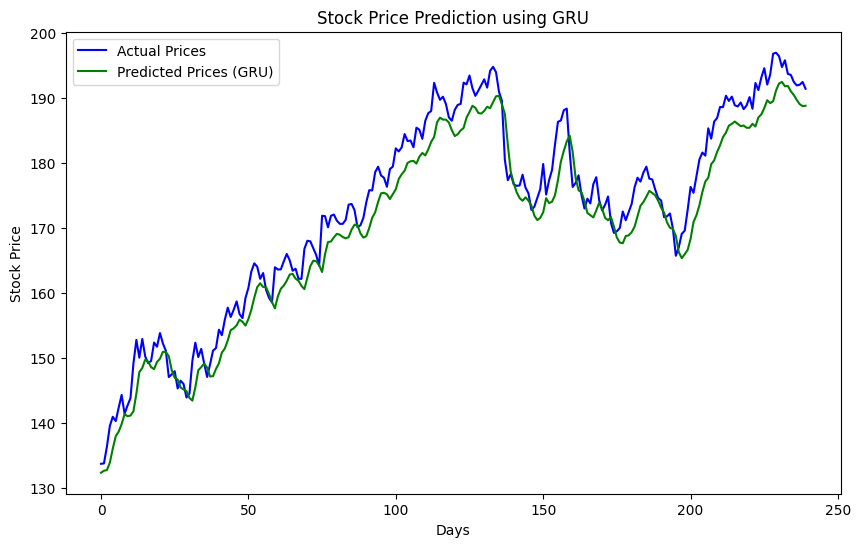

In [18]:
# Evaluate the model on the test set
test_loss_gru = best_gru_model.evaluate(X_test, y_test)
print(f"Test Loss (GRU): {test_loss_gru}")

# Make predictions using the best GRU model
gru_predictions = best_gru_model.predict(X_test)

# Inverse transform predictions to original scale
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices using GRU
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Prices", color='blue')
plt.plot(gru_predictions, label="Predicted Prices (GRU)", color='green')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction using GRU")
plt.show()


Comparison: LSTM vs. GRU

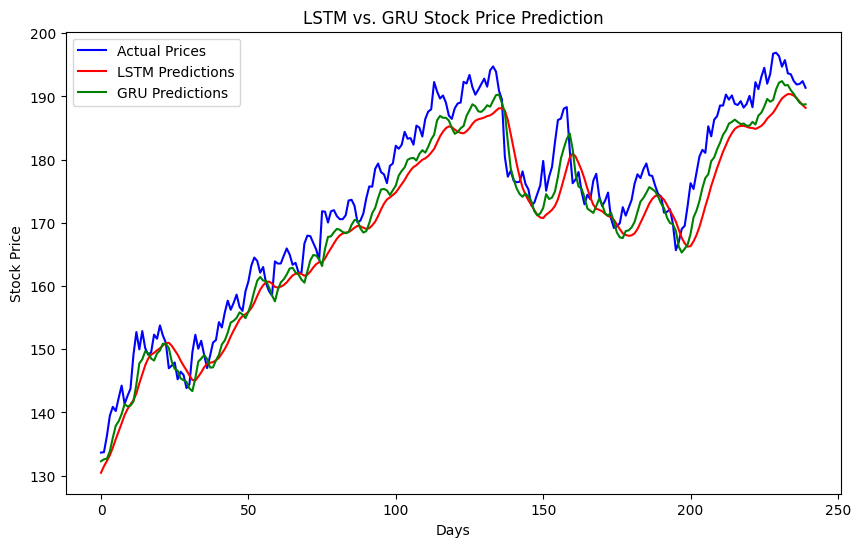

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Prices", color='blue')
plt.plot(predictions, label="LSTM Predictions", color='red')
plt.plot(gru_predictions, label="GRU Predictions", color='green')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("LSTM vs. GRU Stock Price Prediction")
plt.show()
